# Progetto malaria computervision

https://www.tensorflow.org/datasets/catalog/malaria

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanSquaredError, Accuracy, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print('Finished')


Finished


In [2]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split= ['train'])

In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
def splits(dataset, train_ratio, val_ratio, test_ratio):
  dataset_size = len(dataset)
  train_size = int(train_ratio * dataset_size)
  val_size = int(val_ratio * dataset_size)

  train_dataset = dataset.take(train_size)
  val_dataset = dataset.skip(train_size).take(val_size)
  test_dataset = dataset.skip(train_size + val_size)

  return train_dataset, val_dataset, test_dataset


In [5]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_dataset, val_dataset, test_dataset = splits(dataset[0], train_ratio, val_ratio, test_ratio)


In [6]:
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: <_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Validation Dataset: <_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Test Dataset: <_SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## Dataset Visualization

(103, 103, 3)
(115, 157, 3)
(136, 127, 3)
(166, 139, 3)
(148, 133, 3)
(112, 106, 3)
(106, 112, 3)
(124, 130, 3)
(124, 127, 3)
(142, 136, 3)
(163, 127, 3)
(109, 115, 3)
(157, 136, 3)
(124, 142, 3)
(133, 154, 3)
(124, 115, 3)


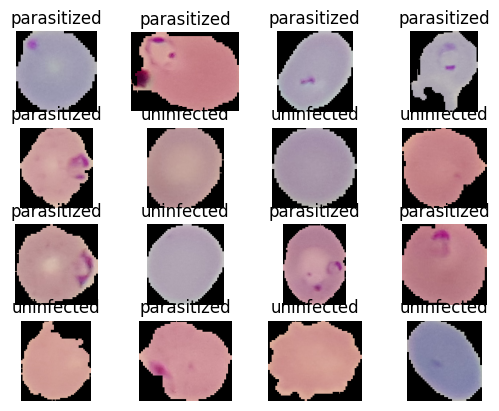

In [7]:
import matplotlib.pyplot as plt

for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image.numpy())  # Use plt.imshow to display the image
    plt.title(dataset_info.features['label'].int2str(label))

    plt.axis('off')
    print(image.shape)

plt.show()


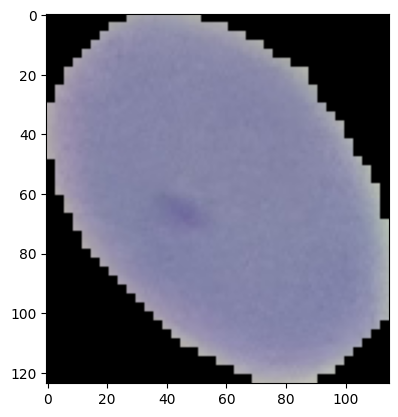

In [8]:
image.numpy()
plt.imshow(image)

## Data Preprocessing


In [9]:
IM_SIZE = 224
def resizing_rescaling(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [10]:
train_dataset = train_dataset.map(resizing_rescaling)
val_dataset = val_dataset.map(resizing_rescaling)
test_dataset = test_dataset.map(resizing_rescaling)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
def apply_data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

    return image, label

train_dataset = train_dataset.map(apply_data_augmentation)
val_dataset = val_dataset.map(apply_data_augmentation)
test_dataset = test_dataset.map(apply_data_augmentation)


In [12]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  ...
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]]

 [[-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  ...
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]]

 [[-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  ...
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]]

 ...

 [[-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  ...
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.06013057]
  [-0.06141698 -0.06173229 -0.060

In [13]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
test_dataset_y = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model Creation

### Feature extractor

In [17]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x


### Lenet

In [18]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 4, 1, "valid", "relu", 3)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_model = LenetModel()
lenet_model(tf.zeros([1,224,224,3]))
lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (Feature  multiple                  1488      
 Extractor)                                                      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  4665700   
                                                                 
 batch_normalization_2 (Bat  multiple                  400       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_3 (Bat  multiple                  

### Callbacks

In [21]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model_checkpoint',
        save_best_only=True,
        save_weights_only=True,  # Salva solo i pesi invece dell'intero modello
    ),
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
]


## Model Creation and Training

In [22]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

In [23]:
lenet_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss=BinaryCrossentropy(),
                   metrics=metrics)


In [ ]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 100,
    verbose = 1,
    callbacks=callbacks
    )


Epoch 1/100
603/603 [==============================] - 50s 83ms/step - loss: 0.0488 - tp: 9521.0000 - fp: 188.0000 - tn: 9463.0000 - fn: 118.0000 - accuracy: 0.9841 - precision: 0.9806 - recall: 0.9878 - auc: 0.9981 - val_loss: 0.1464 - val_tp: 2002.0000 - val_fp: 102.0000 - val_tn: 1964.0000 - val_fn: 65.0000 - val_accuracy: 0.9596 - val_precision: 0.9515 - val_recall: 0.9686 - val_auc: 0.9848 - lr: 1.6000e-06
Epoch 2/100
603/603 [==============================] - 57s 94ms/step - loss: 0.0442 - tp: 9509.0000 - fp: 165.0000 - tn: 9485.0000 - fn: 131.0000 - accuracy: 0.9847 - precision: 0.9829 - recall: 0.9864 - auc: 0.9987 - val_loss: 0.1632 - val_tp: 2004.0000 - val_fp: 105.0000 - val_tn: 1955.0000 - val_fn: 69.0000 - val_accuracy: 0.9579 - val_precision: 0.9502 - val_recall: 0.9667 - val_auc: 0.9826 - lr: 1.6000e-06
Epoch 3/100
603/603 [==============================] - 50s 83ms/step - loss: 0.0456 - tp: 9496.0000 - fp: 172.0000 - tn: 9483.0000 - fn: 139.0000 - accuracy: 0.9839 - pre

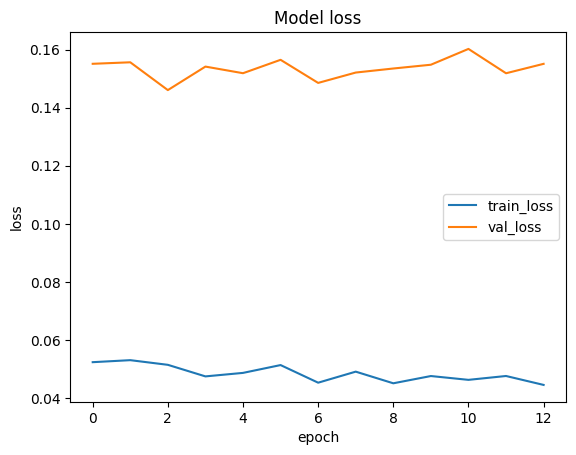

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

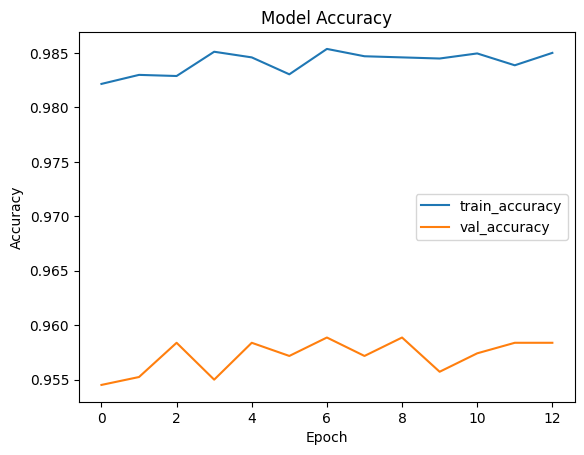

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Confusion matrix

## Model evaluation and Test

In [29]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenet_model.evaluate(test_dataset)

In [ ]:
lenet_model.predict(test_dataset.take(1))[0][0]

In [ ]:
def is_parasite(x):
  if(x<0.5):
    return str('Po')
  return str('Un')

In [ ]:
is_parasite(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image,label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title('y:'+str(is_parasite(label.numpy()[0]))+'| y_hat:'+ str(is_parasite(lenet_model.predict(image)[0][0])))

  plt.axis('off')

## Saving model and loading

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/

In [ ]:
# !cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/

In [ ]:
# lenet_loaded_model = tf.keras.models.load_model("lenets")
# lenet_loaded_model.summary()

In [ ]:
# lenet_model.save("lenet_path", save_format="tf")


In [ ]:
# lenet_model.save_weights("weights/lenet_weights")


In [ ]:
# lenet_weights_model = lenet_model.load_weights("weights/lenet_weights")